# 121 Generate orientation information for robot and pedestrians

In [1]:
load_from_config = True
raw_data_folder = ""
preprocessed_data_folder = ""

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import math
import yaml
import sys
import os
import random

from geopy.distance import geodesic

sys.path.insert(0, os.path.abspath('../src'))
from plot import plot_tracks

In [3]:
with open('../config.yaml') as file:
  params= yaml.safe_load(file)

# in case of a automatic run
if not load_from_config:
    params['raw_data_folder'] = raw_data_folder
    params['preprocessed_data_folder'] = preprocessed_data_folder

preprocessed_data_folder = params['data_folder'] + params['preprocessed_data_folder']

print(params['raw_data_folder'])

raw/20230524/


In [4]:
df_tracks = pd.read_pickle(preprocessed_data_folder + 'pp_merged.pkl')
df_robot = pd.read_pickle(preprocessed_data_folder + 'pp_robot.pkl')

In [5]:
df_tracks.columns

Index(['obj.time', 'obj.confidence', 'obj.label', 'obj.position_covariance.0',
       'obj.position_covariance.1', 'obj.position_covariance.2',
       'obj.position_covariance.3', 'obj.position_covariance.4',
       'obj.position_covariance.5', 'obj.tracking_state', 'obj.velocity.0',
       'obj.velocity.1', 'obj.velocity.2', 'gnss.latitude', 'gnss.longitude',
       'gnss.timestamp', 'gnss.time', 'obj.frame', 'obj.label_id_unique',
       'obj.timestamp', 'obj.human_pos.x_sensor', 'obj.human_pos.y_sensor',
       'obj.human_pos.x_robot', 'obj.human_pos.y_robot', 'obj.human_speed',
       'distance_robot', 'angle_robot', 'valid_track', 'obj.cov_area',
       'obj.cov_angle', 'obj.cov_width', 'obj.cov_heigth', 'color',
       'timestamp_gnss', 'robot_before', 'robot_after', 'valid_interpolation',
       'robot_latitude', 'robot_longitude', 'bearing', 'robot_latitude_before',
       'robot_longitude_before', 'robot_latitude_after',
       'robot_longitude_after', 'pose_valid', 'speed', '

In [6]:
def shift_position(latitude, longitude, angle_in_rad, distance_m):
    earth_radius_km = 6371.0  # Average Earth radius in kilometers

    distance_km = distance_m / 1000

    # Calculate new latitude and longitude
    new_latitude = math.degrees(math.asin(math.sin(math.radians(latitude)) * math.cos(distance_km / earth_radius_km) +
                                          math.cos(math.radians(latitude)) * math.sin(distance_km / earth_radius_km) * math.cos(angle_in_rad)))

    new_longitude = math.degrees(math.radians(longitude) + math.atan2(math.sin(angle_in_rad) * math.sin(distance_km / earth_radius_km) * math.cos(math.radians(latitude)),
                                                                      math.cos(distance_km / earth_radius_km) - math.sin(math.radians(latitude)) * math.sin(math.radians(new_latitude))))

    return new_latitude, new_longitude

df_tracks['latitude_human']=np.nan
df_tracks['longitude_human']=np.nan

for index, row in df_tracks.iterrows():
    new_lat, new_lon = shift_position(row['robot_latitude'], row['robot_longitude'], 
                                      row['bearing'] + row['angle_robot'],
                                      row['distance_robot'])
    df_tracks.at[index, 'latitude_human'] = new_lat
    df_tracks.at[index, 'longitude_human'] = new_lon

In [7]:
df_tracks.groupby(['pose_valid', 'valid_track'])['obj.time'].count().unstack()

valid_track,True
pose_valid,
True,5920


In [8]:
df_tracks = df_tracks[df_tracks['pose_valid'] & df_tracks['valid_track']]

In [9]:
orientations = []

def haversine_distance(coord1, coord2):
    if np.isnan(coord1[0]) | np.isnan(coord1[1]) | np.isnan(coord2[0]) | np.isnan(coord2[1]):
        return np.nan
    return geodesic(coord1, coord2).meters

for id in df_tracks['obj.label_id_unique'].unique():
    data = {}
    df = df_tracks[df_tracks['obj.label_id_unique'] == id]

    data['timestamp_begin'] = df.timestamp_gnss.min()
    data['timestamp_end'] = df.timestamp_gnss.max()

    m, b = np.polyfit(df['robot_longitude'], df['robot_latitude'], 1)
    data['obj.label_id_unique'] = id
    data['sample_count'] = df.shape[0]
    data['robot_begin_longitude'] = df.iloc[0]['robot_longitude']
    data['robot_begin_latitude'] = m * df.iloc[0]['robot_longitude'] + b
    data['robot_end_longitude'] = df.iloc[-1]['robot_longitude']
    data['robot_end_latitude'] = m * df.iloc[-1]['robot_longitude'] + b
    data['robot_corr_coeff'] = df['robot_longitude'].corr(df['robot_latitude'])
    data['robot_dir_vector'] = np.array([
        data['robot_end_longitude'] - data['robot_begin_longitude'],
        data['robot_end_latitude'] - data['robot_begin_latitude']
    ])

    m, b = np.polyfit(df['longitude_human'], df['latitude_human'], 1)
    data['human_begin_longitude'] = df.iloc[0]['longitude_human']
    data['human_begin_latitude'] = m * df.iloc[0]['longitude_human'] + b
    data['human_end_longitude'] = df.iloc[-1]['longitude_human']
    data['human_end_latitude'] = m * df.iloc[-1]['longitude_human'] + b
    data['human_corr_coeff'] = df['longitude_human'].corr(df['latitude_human'])
    data['human_dir_vector'] = np.array([
        data['human_end_longitude'] - data['human_begin_longitude'],
        data['human_end_latitude'] - data['human_begin_latitude']
    ])

    max_human_lat = df['latitude_human'].max()
    min_human_lat = df['latitude_human'].min()
    max_human_lon = df['longitude_human'].max()
    min_human_lon = df['longitude_human'].min()
    human_dist = haversine_distance((max_human_lat, max_human_lon), (min_human_lat, min_human_lon))
    human_time = (df['timestamp_gnss'].max() - df['timestamp_gnss'].min()).total_seconds()
    if human_time > 0.5:
        data['human_speed_est'] = human_dist / human_time
    else:
        data['human_speed_est'] = np.nan
    data['human_duration'] = human_time

    data['min_distance'] = df.distance_robot.min()
    data['robot_speed'] = df.speed.mean()
    data['robot_rotation'] = df.heading_diff.mean()
    data['HDOP'] = df.HDOP.mean()

    orientations.append(data)

df_orientations = pd.DataFrame(orientations)
df_orientations.head(3)

/tmp/ipykernel_88925/2436711727.py:15: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(df['robot_longitude'], df['robot_latitude'], 1)
/home/sebastian/.local/share/virtualenvs/visualize_tracking_data-9SWVvaUy/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/sebastian/.local/share/virtualenvs/visualize_tracking_data-9SWVvaUy/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/sebastian/.local/share/virtualenvs/visualize_tracking_data-9SWVvaUy/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_88925/2436711727.py:28: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(df['longitude_human'], df['latitude_human'], 1)


,timestamp_begin,timestamp_end,obj.label_id_unique,sample_count,robot_begin_longitude,robot_begin_latitude,robot_end_longitude,robot_end_latitude,robot_corr_coeff,robot_dir_vector,...,human_end_longitude,human_end_latitude,human_corr_coeff,human_dir_vector,human_speed_est,human_duration,min_distance,robot_speed,robot_rotation,HDOP
0,2023-05-24 08:37:21.453855515,2023-05-24 08:37:28.453878164,10019,15,13.341481,50.918214,13.341490,50.918208,-0.999616,"[8.974949068374372e-06, -5.618214153457757e-06]",...,13.341519,50.918208,-0.448350,"[2.1179549150929233e-05, -5.927983352194133e-06]",0.289577,7.000022,1.210189,0.151335,0.207255,1.252208
1,2023-05-24 08:38:43.455058098,2023-05-24 08:38:58.462677956,10061,115,13.341783,50.918339,13.341918,50.918403,0.999181,"[0.0001349725604420371, 6.46774485772994e-05]",...,13.342026,50.918454,0.758804,"[6.695302184667185e-05, 7.058770724199803e-05]",1.005945,15.007619,10.626483,0.788139,0.091990,0.956494
2,2023-05-24 08:39:33.455083132,2023-05-24 08:39:34.460366249,10099,10,13.342145,50.918501,13.342151,50.918503,0.999902,"[5.784592623570006e-06, 1.6881495241705124e-06]",...,13.342172,50.918513,-0.991429,"[-7.139838249514696e-06, 1.4300157303637206e-05]",1.507734,1.005283,1.773614,0.629478,0.179118,1.336675


In [10]:
def angle_between(v1, v2):
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    return angle

df_orientations['angle_robot_human'] = df_orientations.apply(lambda x: angle_between(x['robot_dir_vector'], x['human_dir_vector']), axis=1)

/tmp/ipykernel_88925/1441227834.py:2: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))


In [11]:
run = preprocessed_data_folder.split("/")[-2]
print(run)

df_tracks['obj.label_id_unique'] = df_tracks['obj.label_id_unique'].astype(int)
df_orientations['obj.label_id_unique']=df_orientations['obj.label_id_unique'].astype(int)

df_tracks['obj.label_id_width_date']=df_tracks['obj.label_id_unique'].astype(str) + "_" + run
df_orientations['obj.label_id_width_date']=df_orientations['obj.label_id_unique'].astype(str) + "_" + run

20230524


In [12]:
preprocessed_data_folder = params['data_folder'] + params['preprocessed_data_folder']
pd.to_pickle(df_orientations, preprocessed_data_folder + params['preprocessed_file_labels']+ "orientations.pkl")
pd.to_pickle(df_tracks, preprocessed_data_folder + params['preprocessed_file_labels']+ "merged.pkl")

## Generate test diagrams 

$angle$=0.84
$angle$=1.75
$angle$=0.48
$angle$=1.06
$angle$=3.13
$angle$=0.35
$angle$=0.10
$angle$=0.71
$angle$=0.56
$angle$=0.81
$angle$=3.06
$angle$=2.60
$angle$=2.38
$angle$=0.58
$angle$=0.83
$angle$=3.09
$angle$=3.13
$angle$=2.09
$angle$=2.71
$angle$=3.11
$angle$=1.97
$angle$=3.03
$angle$=2.98
$angle$=0.71
$angle$=0.04
$angle$=0.06
$angle$=2.51
$angle$=1.09
$angle$=nan
$angle$=3.06
$angle$=2.62
$angle$=2.04
$angle$=0.12
$angle$=1.07
$angle$=1.79
$angle$=0.36
$angle$=2.79
$angle$=3.03
$angle$=1.31
$angle$=3.07
$angle$=0.02
$angle$=3.01
$angle$=2.79
$angle$=3.09
$angle$=0.03
$angle$=2.79
$angle$=0.60
$angle$=2.93
$angle$=2.49
$angle$=0.13
$angle$=0.14
$angle$=1.73
$angle$=3.11
$angle$=1.07
$angle$=2.15
$angle$=3.08
$angle$=2.64
$angle$=0.03
$angle$=2.75
$angle$=0.34
$angle$=2.99
$angle$=0.05
$angle$=2.28
$angle$=0.15


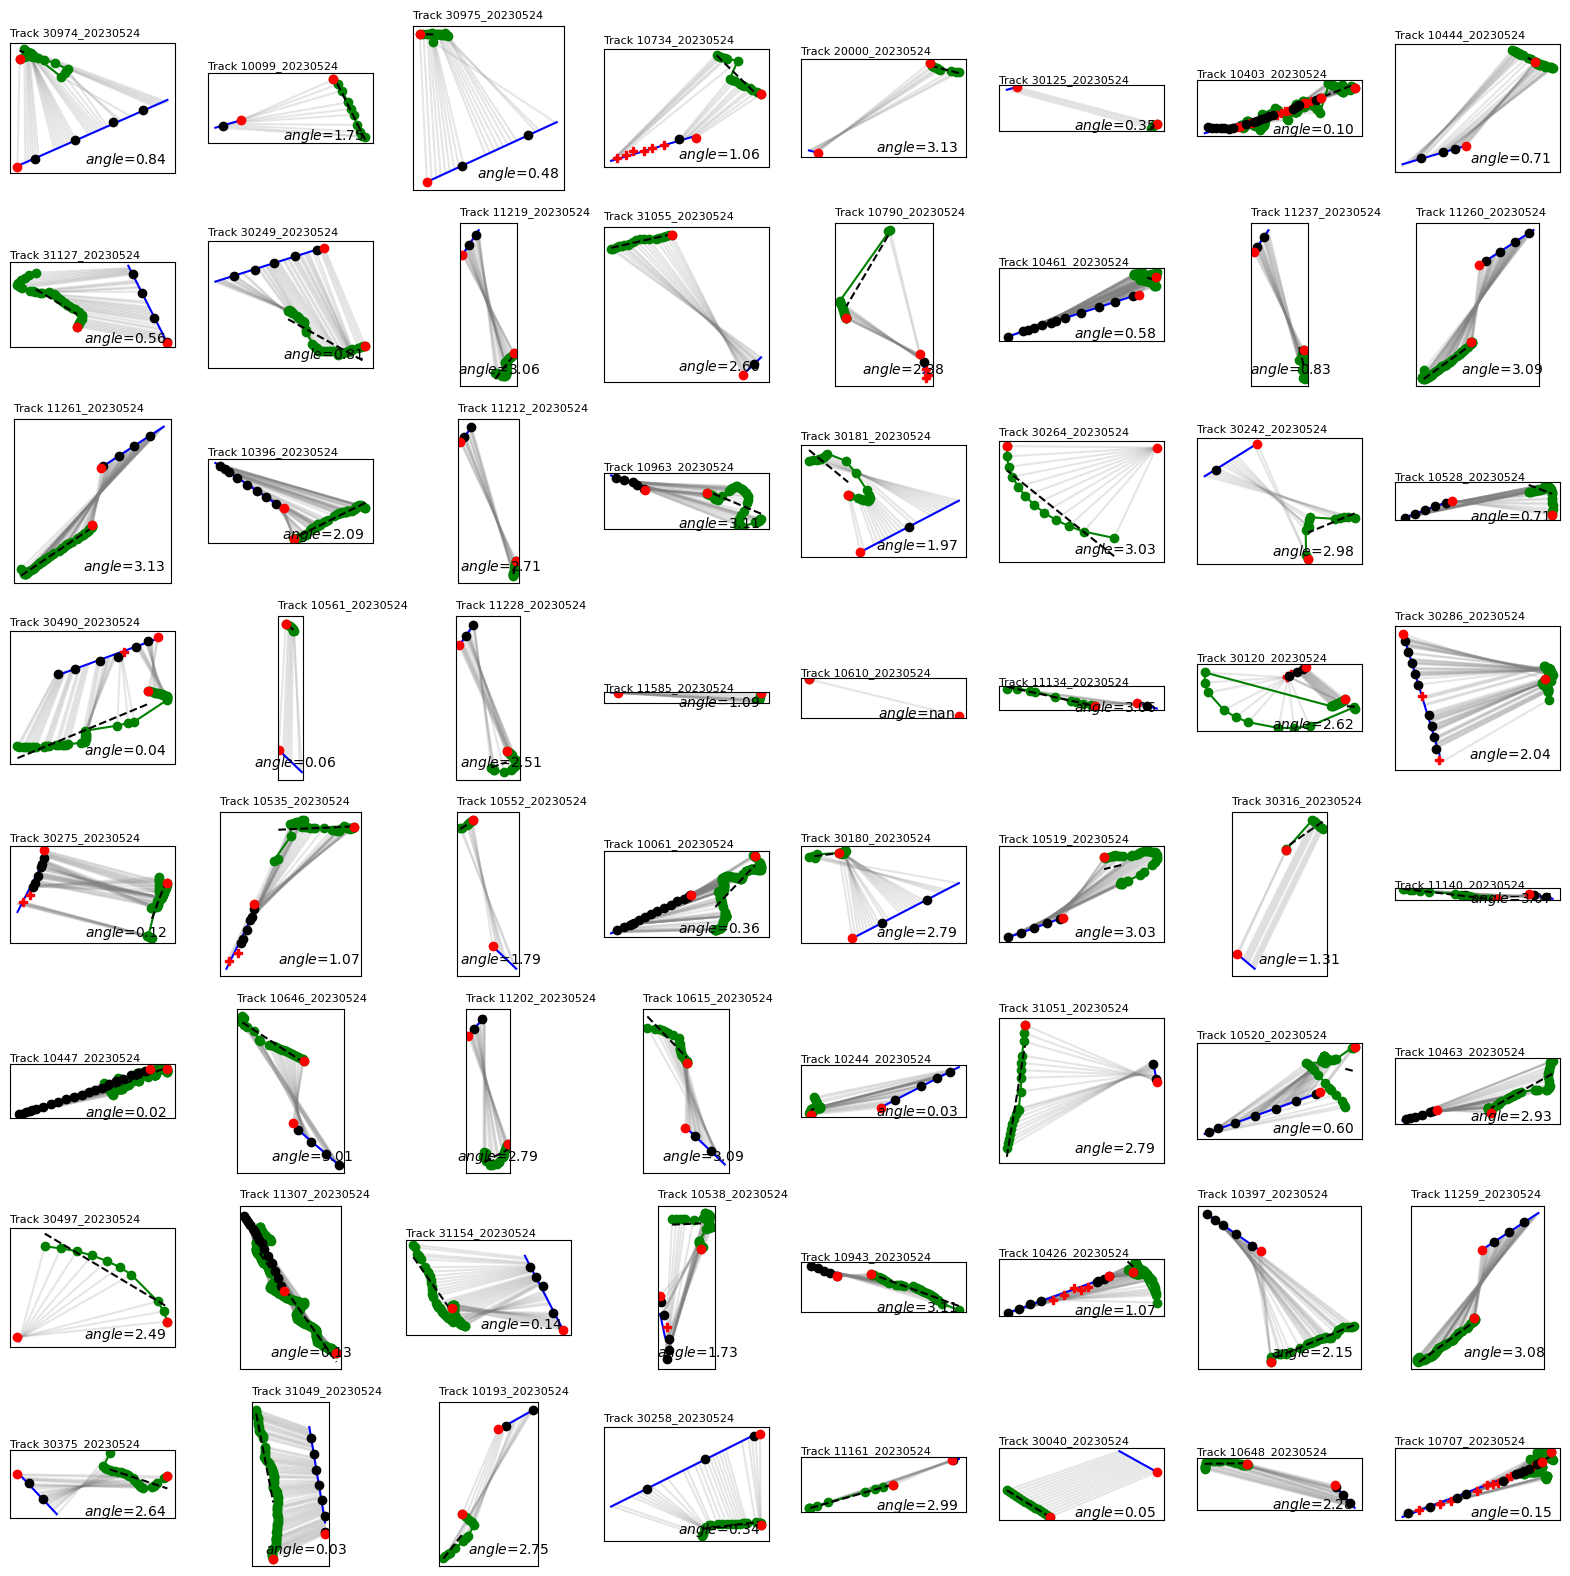

In [13]:
df_tracks['obj.label_id_width_date']=df_tracks['obj.label_id_unique'].astype(str) + "_" + run
df_orientations['obj.label_id_width_date']=df_orientations['obj.label_id_unique'].astype(str) + "_" + run
# Only frontside included
ids = df_tracks[(df_tracks['obj.label_id_unique']<19999)]['obj.label_id_width_date'].unique().tolist()
# Only backside excluded
ids = df_tracks[(df_tracks['obj.label_id_unique']<39999)]['obj.label_id_width_date'].unique().tolist()

relevant_ids = random.sample(ids, 64)

fig, axes = plt.subplots(8, 8, figsize=(20,20))
for i, ax in enumerate(axes.flatten()):
    # Person
    id = relevant_ids[i]
    plot_tracks(ax, id, False, df_tracks, df_robot, df_orientations)

plt.savefig(preprocessed_data_folder + run +"_tracks.png")

In [14]:
if False:
    track_id = "10889.0_20231206"
    track_id = "11540_20231210"
    df = df_tracks[(df_tracks['obj.label_id_width_date'] == track_id) ]

    fig = plt.figure(figsize=(10,10))

    ax = plt.subplot(231)
    df.plot.scatter(x='obj.human_pos.x_sensor', y='obj.human_pos.y_sensor', 
                    c='red', s=3, label=track_id, ax= ax)
    df.plot.scatter(x='obj.human_pos.x_robot', y='obj.human_pos.y_robot', 
                    c='blue', alpha=0.5 ,s=3, ax= ax)
    ax.set_xlim(-12,12)
    ax.set_ylim(-0,12)
    ax.grid()
    ax.set_aspect('equal', 'box')
    ax.set_title('Sensor frame')

    ax = plt.subplot(232, polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rmax(12)
    ax.plot(df['angle_robot'], df['distance_robot'], '.')
    ax.set_title('Robot frame')

    ax = plt.subplot(233, polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    df.plot.hist(y='bearing', bins=10, ax=ax)
    ax.set_title("Robot's orientation")


    ax = plt.subplot(234, polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    for index, row in df.iterrows():
        if row.pose_valid == True:
            marker = '.b'
        else:
            marker = '.r'
        ax.plot(row['angle_robot'] + row['bearing'], row['distance_robot'], marker);
    ax.set_title('Global frame ')

    ax = plt.subplot(235)
    # Connections 
    for index, row in df.iterrows():
        if row.pose_valid == True:
            ax.plot([row['robot_longitude'], row['longitude_human']], 
                    [row['robot_latitude'], row['latitude_human']], '-', 
                    color = 'gray', alpha=0.2)

    # Person
    df[df['pose_valid']==True].plot.scatter(x='longitude_human', y='latitude_human', label='human', ax=ax, color='blue', alpha=0.5)

    # Robots movements
    ax.plot(df['robot_longitude'], df['robot_latitude'], 'og', label='interpolated robot')
    ax.plot(df['robot_longitude_before'], df['robot_latitude_before'], 'or', label='gnss measuremnts robot')
    ax.plot(df['robot_longitude_after'], df['robot_latitude_after'], 'or', label='gnss measuremnts robot')
    ax.set_title(f'Global frame')
    ax.set_aspect('equal', 'box')
    #ax.legend()
